In [2]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32

In [3]:
DOWNLOAD_ROOT= "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
print (DOWNLOAD_ROOT, "datasets/housing/housing.tgz")
print (HOUSING_PATH)

https://raw.githubusercontent.com/ageron/handson-ml2/master/ datasets/housing/housing.tgz
datasets\housing


In [4]:
# fetch data automaticalyy with database is updated
def fetch_housing_data (housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path= os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
# Load data from database
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [36]:
housing = load_housing_data()


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


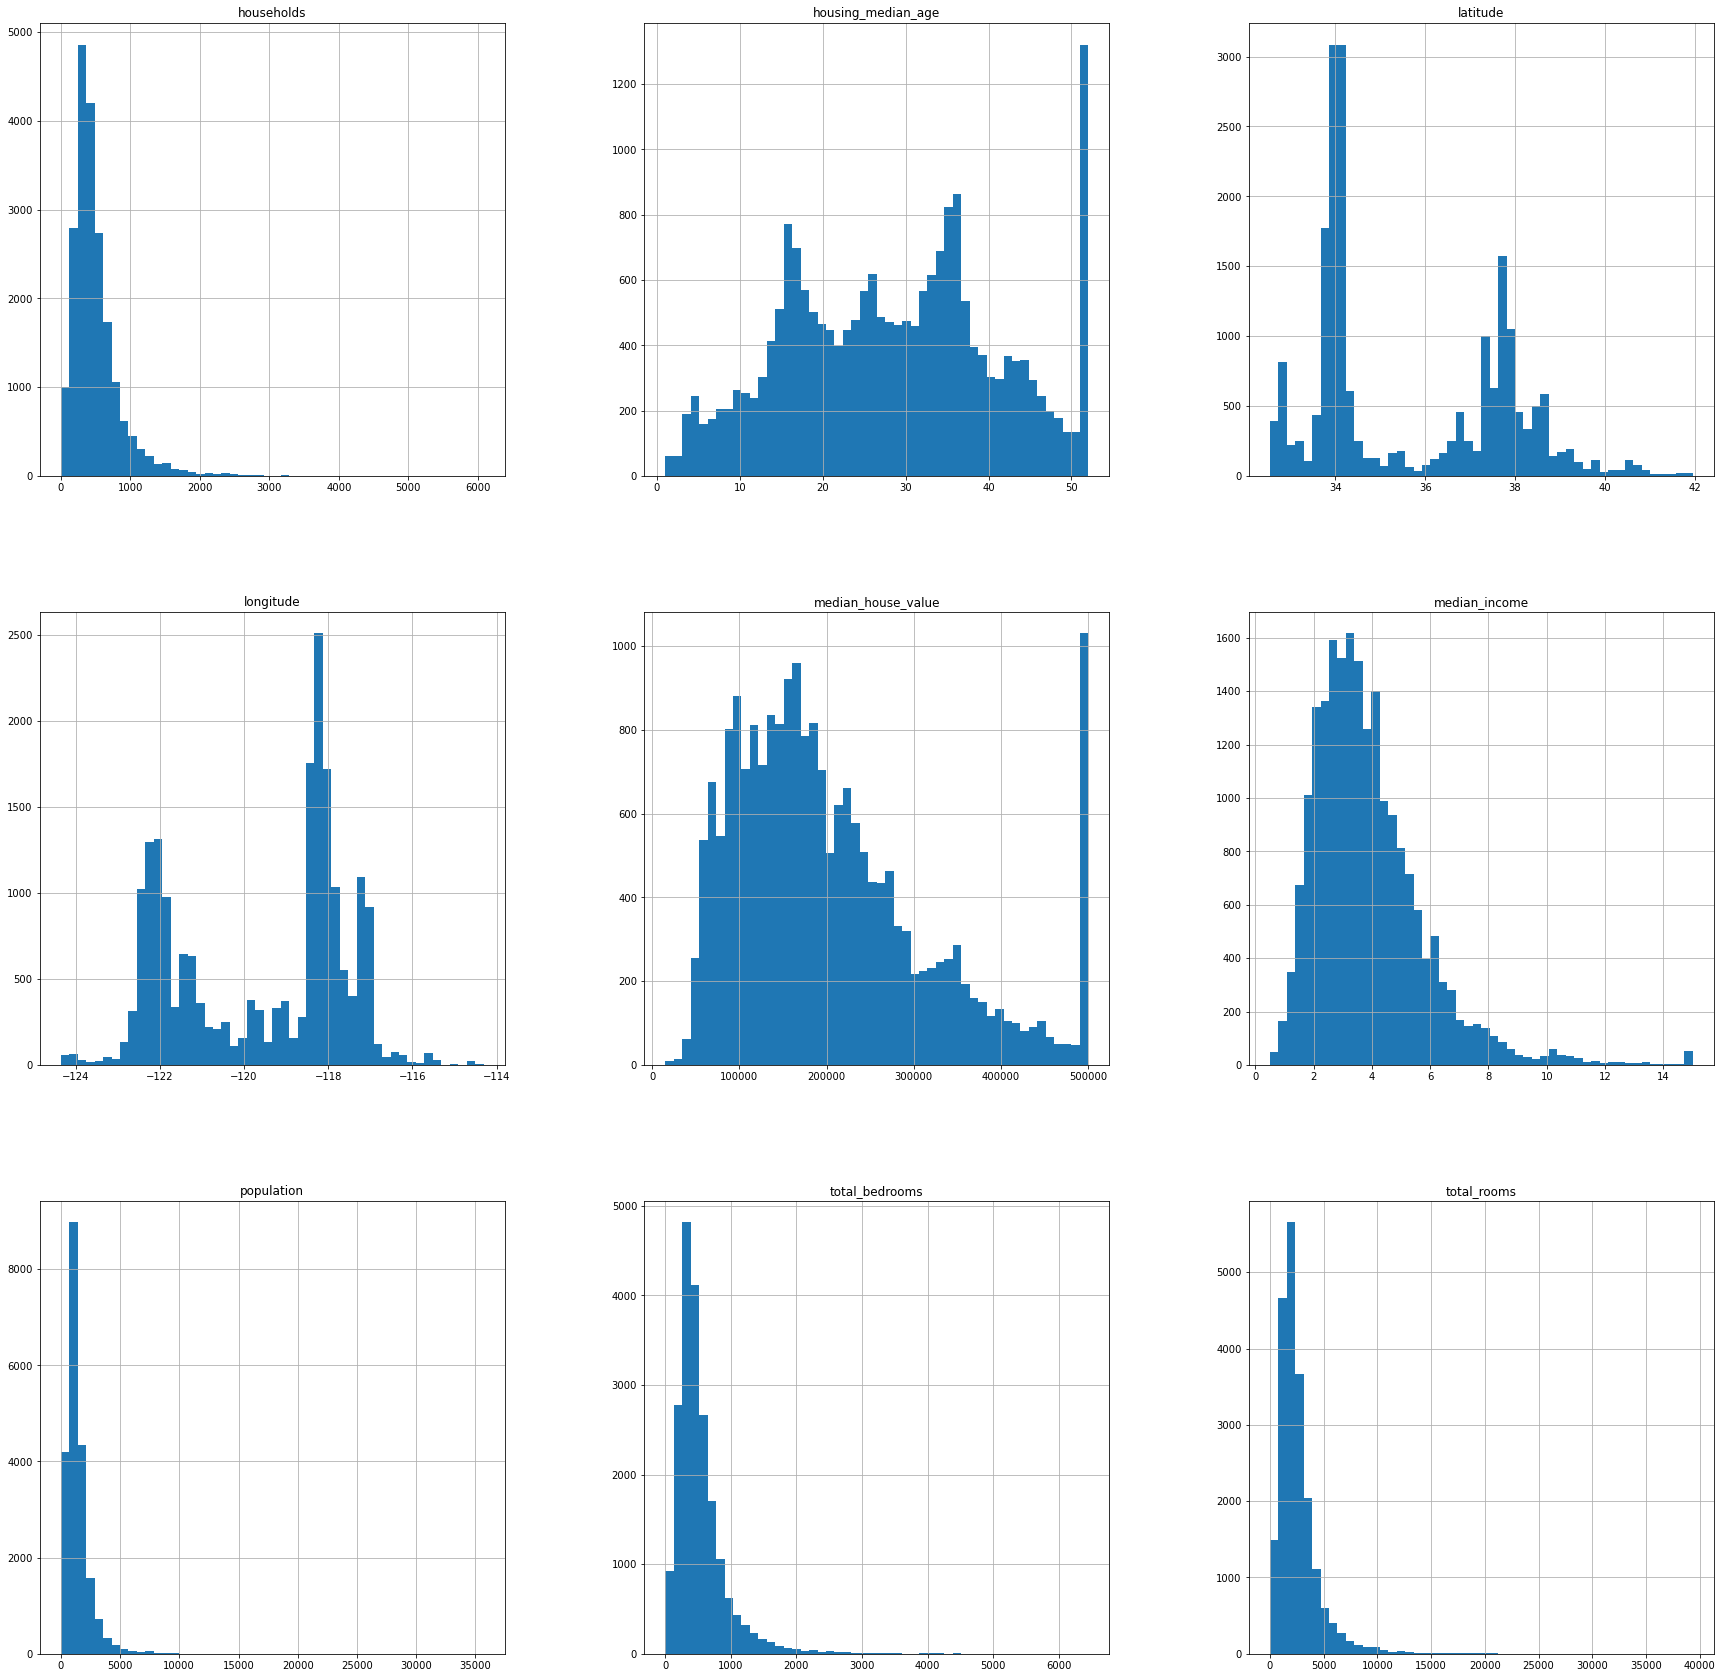

In [8]:
%matplotlib inline
housing.hist(bins=50,figsize=(30,30))
plt.show()

In [9]:
#Split the data into a train set and test set.
#but this is good, because this randomize the data each with new shuffle.
def  split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices =  shuffled_indices [:test_set_size]
    train_indices = shuffled_indices [test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)

In [11]:
len(train_set), len(test_set)


(16512, 4128)

In [15]:
#we build a fuction that seperate the training and test set based on this fuction
def test_set_check (identifier, test_ratio):
    return crc32 (np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


In [1]:
#this will split our data by checking the test_set_check function.
def split_train_test_by_id(data, test_ratio, id_colum):
    ids = data[id_colum ]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [43]:
housing_with_id = housing.reset_index()
ids = housing_with_id['index']
crc32(np.int64(1000)), 0xffffffff , 0.2 * 2**32

(83884832, 4294967295, 858993459.2)

In [15]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
# but scikit-learn make this very easier, lets see.
from sklearn.model_selection import train_test_split

In [17]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
#it is importans to have a sufficient number of instance in our dataset for each stratum.
from sklearn.model_selection import StratifiedShuffleSplit

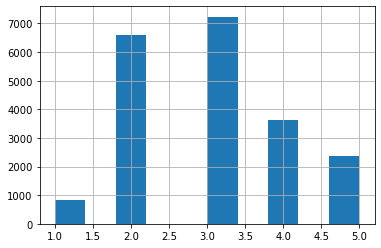

In [19]:
housing['income_cat'] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                              labels= [1,2,3,4,5])
housing['income_cat'].hist()


In [20]:
# ANOTHER SHUFFLING MEATHOD (  BASED ON CATAGORY)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [21]:
strat_test_set.size, strat_train_set.size


(45408, 181632)

In [22]:
# JUST REMOVE IN INCOME_CAT COLUNM FROM THE DATASET.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace= True )
    

# AS OF NOW WE WERE EXPLORING ONLY DATA SPILTING AND DATA CATAGORIZING

# NOW DATA VISUALIZATION

In [23]:
# COPYING THE SET
housing1 = strat_train_set.copy()


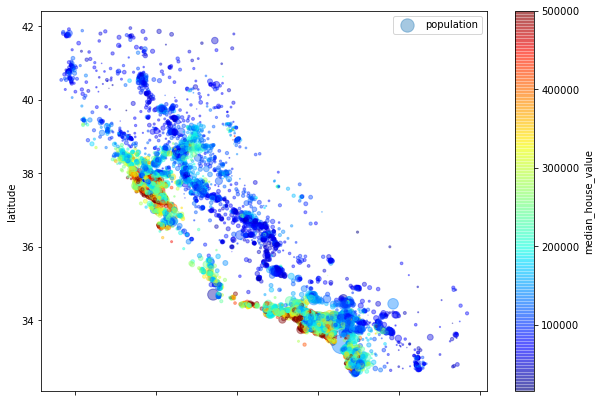

In [24]:
housing1.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
              s=housing1["population"]/100,label="population", figsize=(10,7),
              c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

#This image tells you that the housing prices are very much related to the location
#(e.g., close to the ocean) and to the population density, as you probably knew already

# Looking for correlations

In [25]:
corr_matrix = housing1.corr()

In [26]:
corr_matrix 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [27]:
#from pandas.plotting import scatter_matrix



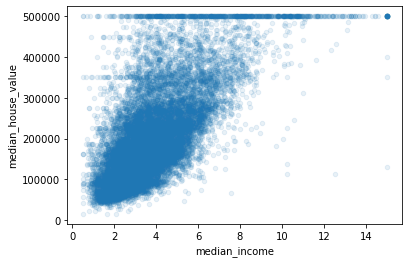

In [28]:
housing1.plot(kind= "scatter", x = 'median_income', 
              y= "median_house_value", alpha=0.1)
# to check the colour plot c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
#the correlation is indeed very strong;
# the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000
# at 450000 and 350000, 280000

In [29]:
housing1["room_per_household"]= housing1["total_rooms"]/housing1["households"]
housing1["bedrooms_per_room"] = housing1["total_bedrooms"]/housing1["total_rooms"]
housing1["population_per_household"]= housing1["population"]/housing1["households"]

In [30]:
corr_matrix = housing1.corr()

In [31]:
corr_matrix["median_house_value"].sort_values()

bedrooms_per_room          -0.259984
latitude                   -0.142724
longitude                  -0.047432
population                 -0.026920
population_per_household   -0.021985
total_bedrooms              0.047689
households                  0.064506
housing_median_age          0.114110
total_rooms                 0.135097
room_per_household          0.146285
median_income               0.687160
median_house_value          1.000000
Name: median_house_value, dtype: float64

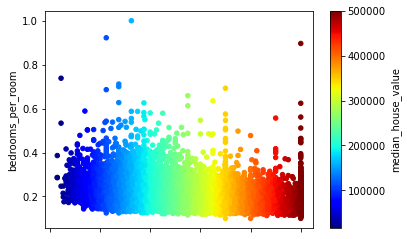

In [32]:
housing1.plot(kind= 'scatter', x='median_house_value' , y= 'bedrooms_per_room',
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

In [33]:
#DROP (COPYING) THE TRAIN SET WITHOUT MEDIAN_HOUSE_VALUE.
# we don’t necessarily want to apply the same transformations to the predictors and the target values 
housing1 = strat_train_set.drop("median_house_value", axis=1)
housing1_labels = strat_train_set["median_house_value"].copy()



# DATA CLEANING


In [34]:
#FILLING NOT AVAILABLE DATA, WITH THREE OPTION THAT THREE OPTION REFER BOOK
median = housing1["total_bedrooms"].median()
housing1["total_bedrooms"].fillna(median, inplace=True)


In [35]:
from sklearn.impute import SimpleImputer

In [36]:
impute = SimpleImputer(strategy='median')

In [37]:
# simpleimputer is only for numerical our case ocean_proximity is not a  numerical.
housing1_num= housing1.drop("ocean_proximity", axis=1)
housing1_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [38]:
impute.fit(housing1_num)

#The imputer has simply computed the median of each attribute and stored the result
#in its statistics_ instance variable


print(housing1_num.median().values)
impute.statistics_

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [39]:
X = impute.transform(housing1_num)
X
#this function will store our data as Numpy array
#Impute all missing values in X.

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [40]:
housing1_tr = pd.DataFrame(X, columns=housing1_num.columns,
                           index=housing1_num.index)

In [41]:
housing_cat = housing1[["ocean_proximity"]]

In [42]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_enconder = OrdinalEncoder()
housing_cat_encoded = ordinal_enconder.fit_transform(housing_cat)
#giving catogeries to the ocean_proximity, because it is not numeric. ML is god working with numerics.

In [43]:
ordinal_enconder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(type(housing_cat_1hot))
housing_cat_1hot.toarray()


<class 'scipy.sparse.csr.csr_matrix'>


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [45]:
print(cat_encoder.categories_)
housing_cat['ocean_proximity'].head()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

## Custom Transformers

You can get the last one for free by simply adding TransformerMixin as a base class.
If you add BaseEstimator as a base class (and avoid *args and **kargs in your con‐
structor), you will also get two extra methods (get_params() and set_params()) that
will be useful for automatic hyperparameter tuning.

In [46]:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


Adding features od hyperparameter buy creating our own class, this help us to find great combinations.

In [47]:



from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder (BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        room_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix]/ X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/ X[:, rooms_ix]
            return np.c_[X, room_per_household,population_per_household,
                        bedrooms_per_room]
        else: 
            return np.c_[X, room_per_household, population_per_household]

In [48]:
add_attributes = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = add_attributes.transform(housing.values)
housing_extra_attributes_num = add_attributes.transform(housing1_num.values)
housing_extra_attributes_num.shape
housing1_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [49]:
#preparing the Data frame

housing_extra_attributes_Data = pd.DataFrame(
    housing_extra_attributes,
    columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income',
             'median_house_value', 'ocean_proximity', 'income_cat','room_per_household',
             'population_per_household'])
housing_extra_attributes_Data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,room_per_household,population_per_household
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.98413,2.55556
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.23814,2.10984
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,5,8.28814,2.80226
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY,4,5.81735,2.54795
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY,3,6.28185,2.18147


In [50]:
print(housing['total_rooms'].max())
print(housing['total_rooms'].min())


39320.0
2.0


## Feature scaling

One of the most important transformations you need to apply to your data is feature
scaling. because the value may vary from one value to another value.(see above output)

min-max scaling and standardization.

# MIN-MAX SCALING(NORMALIZATION)

In [51]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmax_scaling = MinMaxScaler(feature_range=(0,1))
housing_minmax = minmax_scaling.fit_transform(housing1_num)

housing_minmax.shape
housing1_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [52]:
housing_maxmin_Data = pd.DataFrame(
    housing_minmax,
    columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income'])

In [53]:
housing_maxmin_Data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.245020,0.504782,0.725490,0.039731,0.056218,0.019816,0.062920,0.152019
1,0.241036,0.479277,0.254902,0.017119,0.017075,0.008492,0.020724,0.408374
2,0.712151,0.024442,0.588235,0.049499,0.075548,0.026150,0.085885,0.162908
3,0.472112,0.400638,0.470588,0.046828,0.059439,0.040836,0.065534,0.095447
4,0.573705,0.179596,0.313725,0.167523,0.245329,0.124891,0.272778,0.174811


# STANDARDIZATION

In [54]:
stand_scalar = StandardScaler()
housing_stand_scalar = stand_scalar.fit_transform(housing1_num)

In [55]:
housing_standscalar_Data = pd.DataFrame(
    housing_stand_scalar,
    columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income'])
housing_standscalar_Data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437


In [56]:
print (housing_maxmin_Data['total_rooms'].max(), housing_standscalar_Data['total_rooms'].max())

0.9999999999999999 17.161139366477073


In [57]:
housing_standscalar_Data.var()
housing_maxmin_Data.loc[3]

longitude             0.472112
latitude              0.400638
housing_median_age    0.470588
total_rooms           0.046828
total_bedrooms        0.059439
population            0.040836
households            0.065534
median_income         0.095447
Name: 3, dtype: float64

# Transformation Pipelines

## there are many data transformation steps that need to be executed in the right order. 

 the Pipeline class to help with
such sequences of transformations. 

In [58]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scalar', StandardScaler())])

housing_num_tr = num_pipeline.fit_transform(housing1_num)

In [59]:
housing1_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [60]:
housing_num_tr_Data = pd.DataFrame(
    housing_num_tr,
    columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income','room_per_household',
             'population_per_household','bedrooms_per_room'])
housing_num_tr_Data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,room_per_household,population_per_household,bedrooms_per_room
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928


# ColumnTransformer

In [61]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing1_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)])

In [82]:
housing_prepared = full_pipeline.fit_transform(housing1)


# Select and Train a Model

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing1_labels)

LinearRegression()

In [64]:
some_data = housing1.iloc[:5]
some_labels = housing1_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print ("Predictions:", lin_reg.predict(some_data_prepared))
print('Labels : ', list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels :  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


## It works, although the predictions are not exactly accurate

In [65]:
from sklearn.metrics import r2_score, mean_squared_error

housing1_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing1_labels, housing1_prediction)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)


print("R2-score: %.2f" % r2_score(housing1_prediction ,housing1_labels ) )

68628.19819848923
R2-score: 0.46


In [66]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing1_labels)

DecisionTreeRegressor()

In [67]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing1_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## the model has badly overfit the data


 # Better Evaluation Using Cross-Validation

In [68]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score (tree_reg, housing_prepared, housing1_labels,
                         scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [69]:
tree_rmse_scores

array([68203.67645071, 65193.05682289, 70592.10374313, 69332.99665466,
       70688.56028197, 74352.15481683, 72328.53502652, 69635.40665324,
       75850.12760666, 70780.8288594 ])

In [70]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation :",scores.std()) 

In [71]:
display_scores(tree_rmse_scores)
# execute..! each time it gives new value.

Scores: [68203.67645071 65193.05682289 70592.10374313 69332.99665466
 70688.56028197 74352.15481683 72328.53502652 69635.40665324
 75850.12760666 70780.8288594 ]
Mean: 70695.74469160134
Standard deviation : 2865.177337613773


### Let's look at linear regression

In [72]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing1_labels,
                            scoring= "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [73]:
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation : 2731.6740017983425


### no...! , DecisionTreeRegression seems to perform worse than the Linear Regression model! 

### the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model

# random forest

In [91]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing1_labels)

RandomForestRegressor()

In [97]:
housing_prediction_forest = forest_reg1.predict(housing_prepared)
forest_mse = mean_squared_error(housing1_labels, housing_prediction_forest)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

19640.319995761718

In [98]:
forest_scores = cross_val_score(forest_reg1, housing_prepared, housing1_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [99]:
display_scores(forest_rmse_scores)

Scores: [48827.72313807 48563.09325095 50095.84987284 51723.46422623
 48869.59816653 53102.47986745 48423.49274064 48873.19497542
 51941.69569675 49726.16462172]
Mean: 50014.675655661245
Standard deviation : 1578.5980730852755


# fine- tuning


## Grid search
One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values.
#### GridSearchCV
 it will use cross-validation to evaluate all the possible combinations of hyperparameter values. 

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid =[
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators': [30,10], 'max_features':[2,3,4]},]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing1_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [30, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30)

In [96]:

forest_reg1 = RandomForestRegressor(n_estimators=30, max_features=4)
forest_reg1.fit(housing_prepared, housing1_labels)

RandomForestRegressor(max_features=4, n_estimators=30)

In [101]:
cvres = grid_search.cv_results_
for mean_score, params in  zip(cvres["mean_test_score"], cvres["params"]):
    print (np.sqrt(-mean_score), params)

63261.205467540065 {'max_features': 2, 'n_estimators': 3}
55917.07496843363 {'max_features': 2, 'n_estimators': 10}
52942.767425645034 {'max_features': 2, 'n_estimators': 30}
60749.75500131877 {'max_features': 4, 'n_estimators': 3}
52996.55340664341 {'max_features': 4, 'n_estimators': 10}
50631.31459839486 {'max_features': 4, 'n_estimators': 30}
58889.07253785897 {'max_features': 6, 'n_estimators': 3}
52191.331191498226 {'max_features': 6, 'n_estimators': 10}
49963.57161087815 {'max_features': 6, 'n_estimators': 30}
58804.301088818254 {'max_features': 8, 'n_estimators': 3}
51888.6345642556 {'max_features': 8, 'n_estimators': 10}
50177.53688995295 {'max_features': 8, 'n_estimators': 30}
52089.18381344759 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
54256.13500433785 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
50134.017404285296 {'bootstrap': False, 'max_features': 3, 'n_estimators': 30}
52345.3535287587 {'bootstrap': False, 'max_features': 3, 'n_estimators

# Evaluate Your System on the Test Set

In [103]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test) # do not use fit_transforms.

final_prediction = final_model.predict(X_test_prepared)

In [105]:
final_mse = mean_squared_error(y_test, final_prediction)
final_mse = np. sqrt(final_mse)
final_mse

47669.54634804187

In [106]:
# you can compute a 95% confidence interval for the generalization error using scipy
from scipy import stats
confidence = 0.95
squared_errors = (final_prediction-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(),
                        scale= stats.sem(squared_errors)))

array([45728.08203935, 49534.97563398])